In [2]:
import open3d as o3d
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial.transform import Rotation

Frame 0: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 1: Lateral Error = 0.04 meters, Compute Time = 0.04 seconds
Frame 2: Lateral Error = 0.04 meters, Compute Time = 0.04 seconds
Frame 3: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 4: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 5: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 6: Lateral Error = 0.05 meters, Compute Time = 0.05 seconds
Frame 7: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 8: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 9: Lateral Error = 0.05 meters, Compute Time = 0.09 seconds
Frame 10: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 11: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 12: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 13: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame 14: Lateral Error = 0.05 meters, Compute Time = 0.04 seconds
Frame

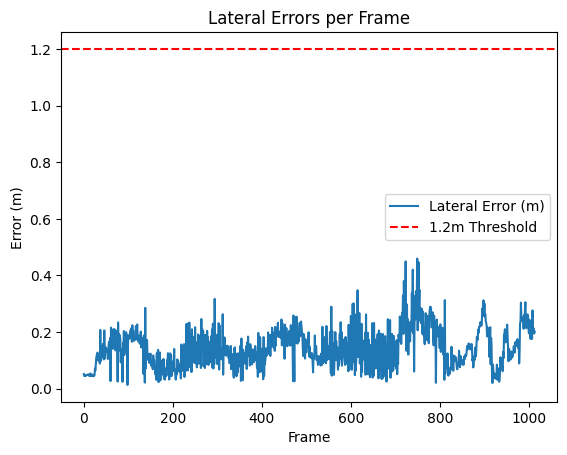

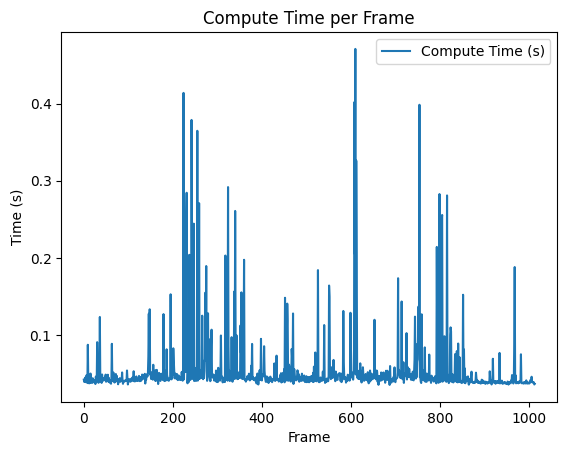

Average Lateral Error: 0.14 meters
Max Lateral Error: 0.46 meters
Average Compute Time: 0.05 seconds


In [2]:
def load_point_clouds(frame_dir):
    frame_files = [os.path.join(frame_dir,'frame_' + str(f) + '.pcd') for f in range(len(os.listdir(frame_dir)))]
    return [o3d.io.read_point_cloud(file) for file in frame_files]

def downsample(pcd, voxel_size):
    return pcd.voxel_down_sample(voxel_size=voxel_size)

def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = downsample(pcd, voxel_size)
    pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.5, max_nn = 100))
    return pcd_down


def icp_registration(source, target, threshold, trans_init):
    icp = o3d.pipelines.registration.registration_icp(
        source = source, target = target, max_correspondence_distance = threshold, init = trans_init,
        estimation_method = o3d.pipelines.registration.TransformationEstimationPointToPlane(), criteria = o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 100))
    return icp

def load_ground_truth(ground_truth_file):
    return pd.read_csv(ground_truth_file)


# Load the map point cloud
map_path = r"dataset/map.pcd"  
map_pcd = o3d.io.read_point_cloud(map_path)

# Load the frames
frame_dir = r"dataset/frames"   
frames = load_point_clouds(frame_dir)

# Downsample and preprocess the point clouds
voxel_size = 0.25
map_down = preprocess_point_cloud(map_pcd, voxel_size)
frames_down = [preprocess_point_cloud(frame, voxel_size) for frame in frames]

# Configure the ICP module
threshold = 2.0
trans_init = np.eye(4)

lateral_errors = []
compute_times = []
transformations = []  # List to store transformations

# Load ground truth data
ground_truth_file = r"dataset/ground_truth.csv"
ground_truth = load_ground_truth(ground_truth_file)

# Remove leading spaces from column names
ground_truth.columns = ground_truth.columns.str.strip()

# Access the columns without leading spaces
ground_truth_poses = ground_truth[['x', 'y', 'z', 'roll', 'pitch', 'yaw']].values

for i, frame in enumerate(frames_down):
    start_time = time.time()
    result = icp_registration(frame, map_down, threshold, trans_init)
    compute_time = time.time() - start_time
    compute_times.append(compute_time)
    
    transformation = result.transformation
    transformations.append(transformation)  # Store transformation
    lateral_error = np.linalg.norm(transformation[:2, 3] - ground_truth_poses[i, :2])  # Assuming 2D lateral error
    lateral_errors.append(lateral_error)
    
    trans_init = transformation  # Update initial transformation

    print(f"Frame {i}: Lateral Error = {lateral_error:.2f} meters, Compute Time = {compute_time:.2f} seconds")
    



# Plot lateral errors
plt.figure()
plt.plot(lateral_errors, label='Lateral Error (m)')
plt.axhline(y=1.2, color='r', linestyle='--', label='1.2m Threshold')
plt.xlabel('Frame')
plt.ylabel('Error (m)')
plt.legend()
plt.title('Lateral Errors per Frame')
plt.show()

# Plot computing times
plt.figure()
plt.plot(compute_times, label='Compute Time (s)')
plt.xlabel('Frame')
plt.ylabel('Time (s)')
plt.legend()
plt.title('Compute Time per Frame')
plt.show()


# Print summary statistics
print(f"Average Lateral Error: {np.mean(lateral_errors):.2f} meters")
print(f"Max Lateral Error: {np.max(lateral_errors):.2f} meters")
print(f"Average Compute Time: {np.mean(compute_times):.2f} seconds")



### NDT 

100.00% |██████████| Frame 1014/1014 , Error: 34.38 Comp. time: 0.22


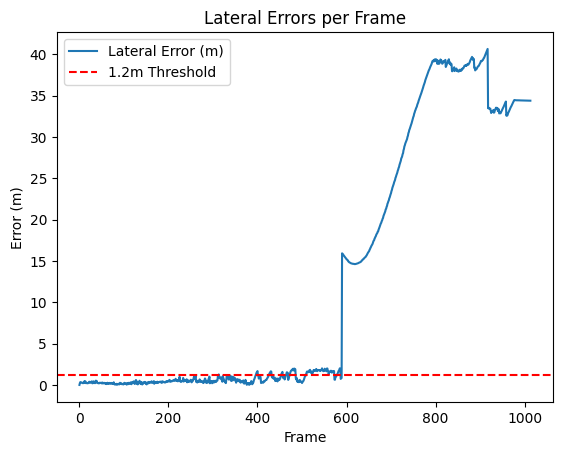

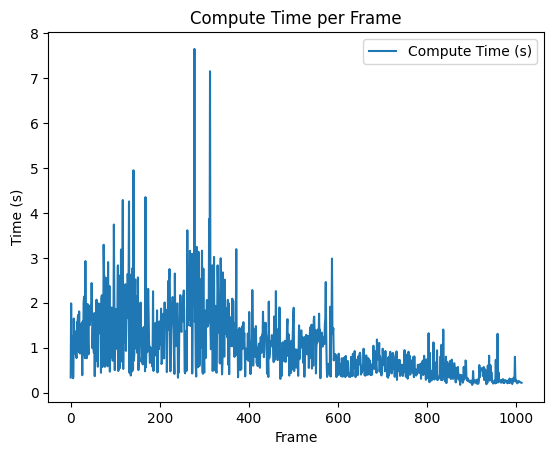

Average Lateral Error: 13.10 meters
Max Lateral Error: 40.65 meters
Average Compute Time: 0.99 seconds


In [3]:
from tools.utils import boundaries, downsample_voxel, pcd_from_path
from tools.NDT import NDT, Pose
from tqdm import tqdm

# Load map point cloud
map_cloud = pcd_from_path("dataset/map.pcd")

# Load ground truth poses
ground_truth = pd.read_csv('dataset/ground_truth.csv')
ground_truth.columns = ['Frame', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

frames_folder = 'dataset/frames'

voxel_size = 0.1
r = 2.0
zlims = [0, 2.8]

errors_position = []
errors_yaw = [] 

bounded_map = boundaries(map_cloud, r=r, zlims=zlims)
voxel_map, voxel_config_show = downsample_voxel(bounded_map, voxel_size=voxel_size)

# Create NDT object
ndt = NDT(x_step=12, y_step=6, xlim=(-20, 200), ylim=(-30, 30))

# Initialize Pose
init_pose = Pose(0,0,0)

# Set input cloud to populate grids
ndt.set_input_cloud(voxel_map)

# Lateral_errors and compute times error
lateral_error = 0
lateral_errors = []
compute_times = []

# Tqdm bar
bar_format = "{percentage:.2f}% |{bar}| Frame {n_fmt}/{total_fmt} {postfix}"
pbar = tqdm(range(len(os.listdir(frames_folder))), bar_format=bar_format)

for frame in pbar:
    start_time = time.time()

    frame_cloud = pcd_from_path(os.path.join(frames_folder, 'frame_' + str(frame) + '.pcd')) # Source points
    
    bounded_frame = boundaries(frame_cloud, r=r, zlims=zlims)
    voxel_frame, voxel_config_show = downsample_voxel(bounded_frame, voxel_size=voxel_size)

    pose, cache = ndt.align(voxel_frame, init_pose, max_iterations=50)
    
    gt = ground_truth.iloc[frame]

    # Assuming 2D lateral error
    lateral_error = np.linalg.norm(np.array((pose.x, pose.y)) - np.array([gt['x'], gt['y']])) 
    lateral_errors.append(lateral_error)

    error_x = gt['x'] - pose.x
    error_y = gt['y'] - pose.y
    error_yaw = gt['yaw'] - pose.yaw

    init_pose = Pose(pose.x, pose.y, pose.yaw) 

    compute_time = time.time() - start_time
    compute_times.append(compute_time)
    
    pbar.postfix = f"Error: {lateral_error:.2f} Comp. time: {compute_time:.2f}"

# Plot lateral errors
plt.figure()
plt.plot(lateral_errors, label='Lateral Error (m)')
plt.axhline(y=1.2, color='r', linestyle='--', label='1.2m Threshold')
plt.xlabel('Frame')
plt.ylabel('Error (m)')
plt.legend()
plt.title('Lateral Errors per Frame')
plt.show()

# Plot computing times
plt.figure()
plt.plot(compute_times, label='Compute Time (s)')
plt.xlabel('Frame')
plt.ylabel('Time (s)')
plt.legend()
plt.title('Compute Time per Frame')
plt.show()


# Print summary statistics
print(f"Average Lateral Error: {np.mean(lateral_errors):.2f} meters")
print(f"Max Lateral Error: {np.max(lateral_errors):.2f} meters")
print(f"Average Compute Time: {np.mean(compute_times):.2f} seconds")



In [ ]:
from tools.utils import animate_ndt_results

animation = animate_ndt_results(voxel_frame, ndt, init_pose, cache, xlim=[-5, 5], ylim=[-5, 5])
animation